<a href="https://colab.research.google.com/github/aryan-at-ul/graph_neural_networks_basics/blob/main/plots_for_journal_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

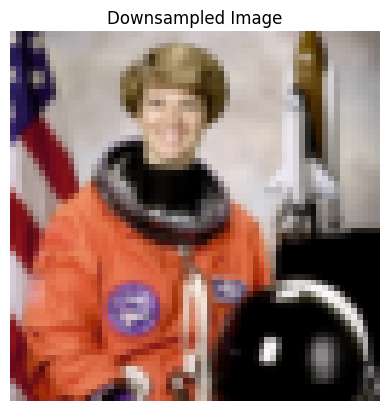

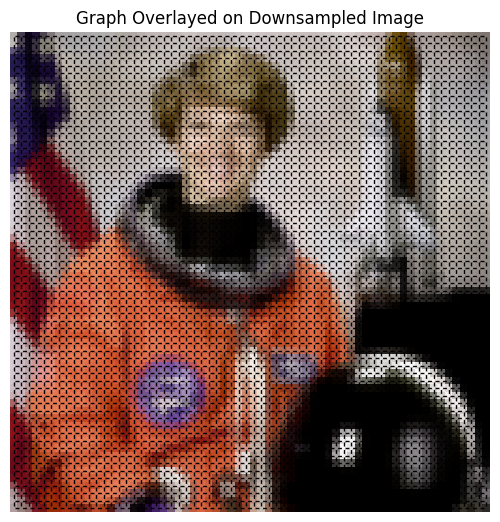

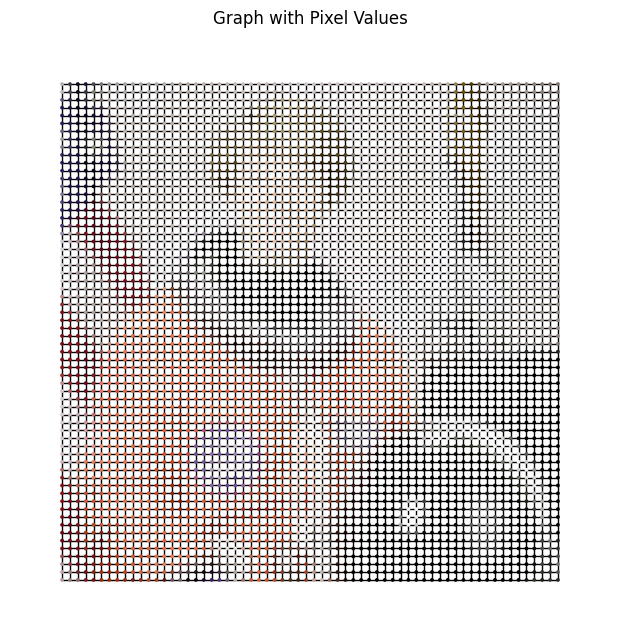

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from skimage import data, transform

# Load a sample image from skimage and downsample it to 66x64
image = data.astronaut()  # Using the astronaut sample image
image_downsampled = transform.resize(image, (64, 64), anti_aliasing=True)

# Plot the downsampled image
plt.imshow(image_downsampled)
plt.title("Downsampled Image")
plt.axis('off')
plt.show()

# Function to convert an image to a graph
def image_to_graph(image):
    rows, cols, _ = image.shape
    G = nx.Graph()

    # Add nodes with RGB features
    for y in range(rows):
        for x in range(cols):
            node_id = (x, y)
            G.add_node(node_id, feature=image[y, x])

    # Add edges between adjacent nodes
    for y in range(rows):
        for x in range(cols):
            if x < cols - 1:
                G.add_edge((x, y), (x + 1, y))  # Edge to right neighbor
            if y < rows - 1:
                G.add_edge((x, y), (x, y + 1))  # Edge to bottom neighbor

    return G

# Convert the downsampled image to a graph
image_graph = image_to_graph(image_downsampled)

# Plot the graph overlaid on the downsampled image
pos = {(x, y): (x, y) for y in range(64) for x in range(64)}


nx.draw(image_graph, pos, node_size=3, node_color=[image_graph.nodes[n]['feature'] for n in image_graph.nodes], edge_color = 'black', with_labels=False)

# Show the combined plot
plt.imshow(image_downsampled)
plt.title("Graph Overlayed on Downsampled Image")
plt.axis('off')
plt.show()

adjusted_pos = {(x, image_downsampled.shape[0] - 1 - y): pos[(x, y)] for (x, y) in pos}

plt.figure(figsize=(6, 6))
nx.draw(image_graph, adjusted_pos, node_size=3, node_color=[image_graph.nodes[n]['feature'] for n in image_graph.nodes], edge_color='black', with_labels=False)
plt.title("Graph with Pixel Values")
plt.axis('off')
plt.show()


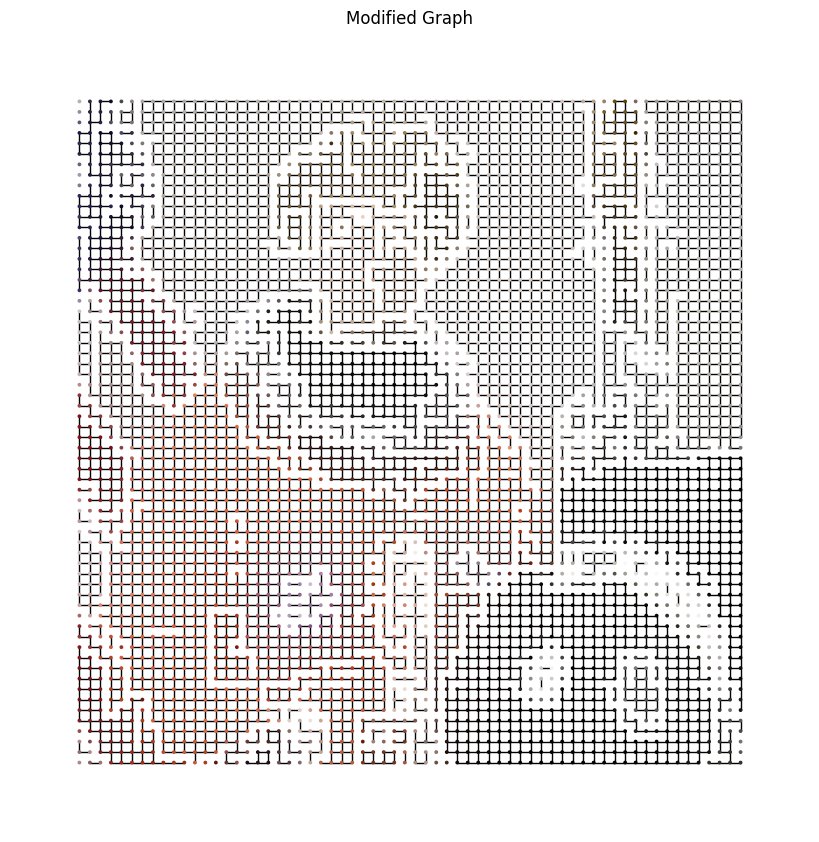

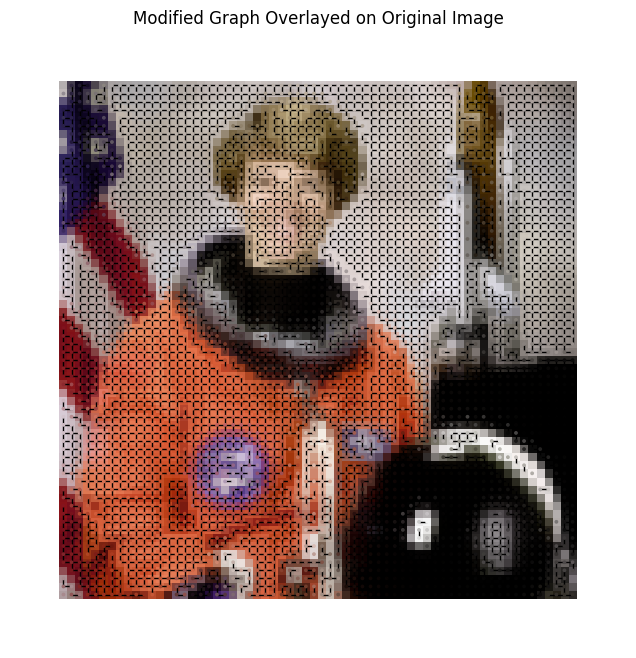

In [14]:
# Assuming n_hop and pixel_threshold are provided, I'll set some default values for them
n_hop = 1
pixel_threshold = 0.1

# Initialize set to keep track of removed edges
removed_edges = set()

# Go through each node and process according to the provided logic
for node in image_graph.nodes():
    # Calculate path lengths to find neighbors within n_hop
    path_lengths = nx.single_source_shortest_path_length(image_graph, node)
    neighbors = [neighbor for neighbor, length in path_lengths.items() if length <= n_hop]

    # Calculate the mean pixel value for the node and its neighbors
    node_pixel_value = np.array(image_graph.nodes[node]['feature']).mean()
    neighbor_pixel_values = np.array([image_graph.nodes[neighbor]['feature'] for neighbor in neighbors]).mean(axis=0)

    # Check and filter edges based on pixel value difference
    for neighbor in neighbors:
        neighbor_pixel_value = np.array(image_graph.nodes[neighbor]['feature']).mean()
        pixel_difference = abs(node_pixel_value - neighbor_pixel_value)

        if image_graph.has_edge(node, neighbor) and (node, neighbor) not in removed_edges:
            if pixel_difference > pixel_threshold:
                # Remove edge if pixel difference is more than the threshold
                image_graph.remove_edge(node, neighbor)
                removed_edges.add((node, neighbor))
                removed_edges.add((neighbor, node))
            elif pixel_difference <= pixel_threshold:
                # Assign mean pixel values to the neighbor node
                image_graph.nodes[neighbor]['feature'] = neighbor_pixel_values

# Plot the final graph
adjusted_pos = {(x, image_downsampled.shape[0] - 1 - y): pos[(x, y)] for (x, y) in pos}
plt.figure(figsize=(8, 8))
nx.draw(image_graph, adjusted_pos, node_size=3, node_color=[image_graph.nodes[n]['feature'] for n in image_graph.nodes], with_labels=False)
plt.title("Modified Graph")
plt.axis('off')
plt.show()

# Plot the graph overlayed on the original image
plt.figure(figsize=(8, 8))
plt.imshow(image_downsampled)
nx.draw(image_graph, pos, node_size=3, node_color=[image_graph.nodes[n]['feature'] for n in image_graph.nodes], with_labels=False)
plt.title("Modified Graph Overlayed on Original Image")
plt.axis('off')
plt.show()

